In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# pip install pyarrow
# !pip install catboost
# !pip install lightgbm

In [3]:
import pandas as pd
import random
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
# filepath=r"D:\SMU\QF 621\Project"
# Return_300=pd.read_feather(filepath+"Return_hs300_new_work.fea")
Return_300=pd.read_feather(r"D:\SMU\QF 621\Project\Return_hs300_new_work.fea")

In [4]:
## Get rid of abnormal values
Return_300=Return_300[Return_300['StockReturn'].abs()<=0.2]
train_names=Return_300.columns[2:-4]

def median_out(x,train_names):
    for train_name in train_names:
        median=x[train_name].median()
        median_median=(x[train_name]-x[train_name].median()).abs().median()
        x=x[(x[train_name]<median+5*median_median)&(x[train_name]>median-5*median_median)]
    return x

In [5]:
#Return_300=Return_300.groupby('date').apply(lambda x:median_out(x,train_names)).reset_index(drop=True)

#Standadization
def stand(x,train_names):
    for train_name in train_names:
        x[train_name]=((x[train_name]-x[train_name].mean())/x[train_name].std()).clip(-3,3)
    return x

In [6]:
##Standardization on cross-sectional aspect and industrial aspect
Return_300=Return_300.groupby('TradingDay').apply(lambda x:stand(x,train_names)).reset_index(drop=True)
Return_300=Return_300.groupby(['TradingDay','FirstIndustryCode']).apply(lambda x:stand(x,train_names)).reset_index(drop=True)

In [7]:
Return_300.reset_index(drop=True).to_feather('Return_hs300_new_work_std.fea')

In [8]:
#Return_300=Return_300_1.copy()

Return_300['StockReturnBy300']=Return_300['StockReturn']-Return_300['MktRetHS300']
Return_300=Return_300.drop('close',axis=1).dropna(axis=0)

train_names=Return_300.columns[2:-5]
target_name='StockReturnBy300'

def get_IC_IR(x,train_names,Return):
    IC_all=[]
    for factor in train_names:
        IC=x[factor].corr(x[Return])
        #IR=x[factor].corr(x[Return]).std()
        IC_one=pd.DataFrame([{'factor':factor,'IC':IC}])
        IC_all.append(IC_one)
    IC_all=pd.concat(IC_all,axis=0,ignore_index=True)
    return IC_all
def get_corr(x,train_names):
    return x[train_names].corr().reset_index(drop=False)
def get_rank_IC_IR(x,train_names,Return):
    rank_IC_all=[]
    for factor in train_names:
        x=x.sort_values(factor)
        x['factor_rank']=np.arange(x.shape[0])
        x=x.sort_values(Return)
        x['Return_rank']=np.arange(x.shape[0])
        IC=x['factor_rank'].corr(x['Return_rank'])
        
        rank_IC_one=pd.DataFrame([{'factor':factor,'rank_IC':IC}])
        rank_IC_all.append(rank_IC_one)
    rank_IC_all=pd.concat(rank_IC_all,axis=0,ignore_index=True)
    return rank_IC_all

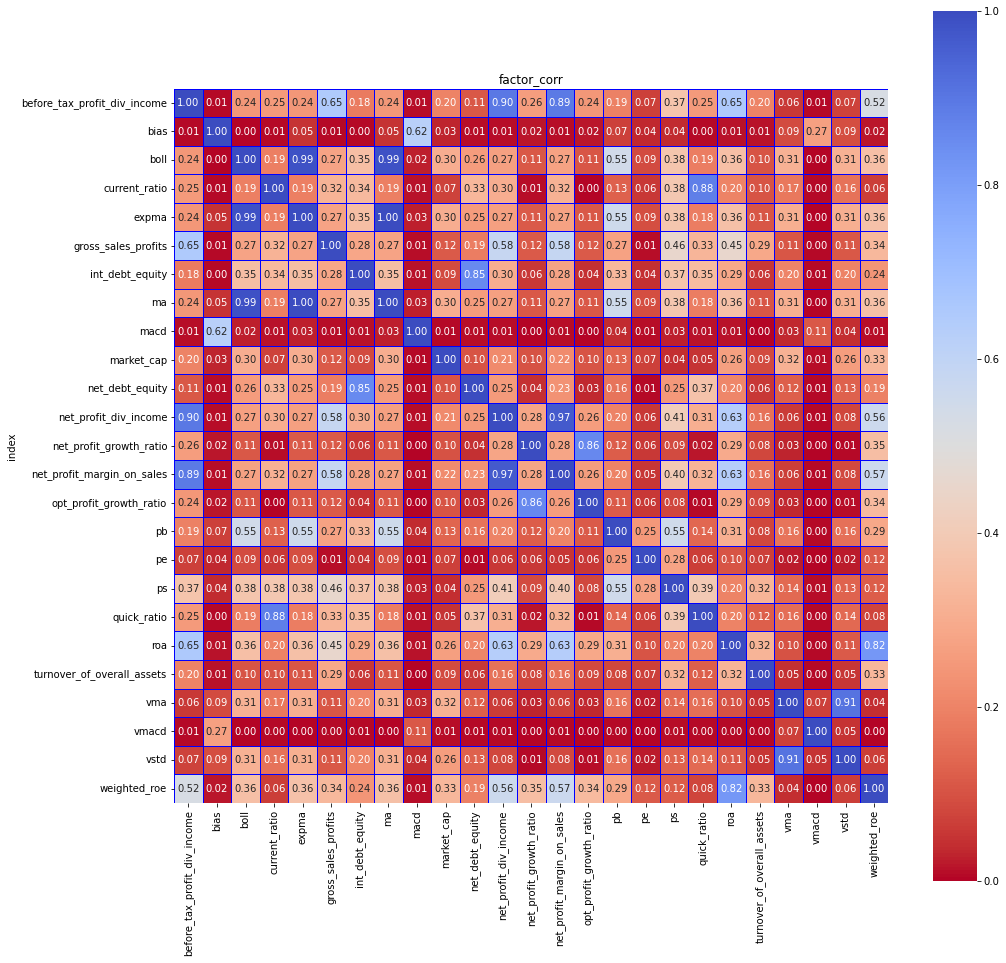

In [9]:
corr_factor_all=Return_300.groupby('TradingDay').apply(lambda x:get_corr(x,train_names)).groupby('index').mean()
corr_factor_all=corr_factor_all.loc[:,corr_factor_all.index.to_list()]
IC_all=Return_300.groupby('TradingDay').apply(lambda x:get_IC_IR(x,train_names,'StockReturn'))
rank_IC_all=Return_300.groupby('TradingDay').apply(lambda x:get_rank_IC_IR(x,train_names,'StockReturn'))
##Get ICIR and rankICIR
IC_IR_all=IC_all.groupby('factor').agg({'IC':['mean','std']})
rank_IC_IR_all=rank_IC_all.groupby('factor').agg({'rank_IC':['mean','std']})
IC_IR_all.columns=['IC','IR']
rank_IC_IR_all.columns=['rank_IC','rank_IR']
IC_IR_all['ICIR']=IC_IR_all['IC']/IC_IR_all['IR']
rank_IC_IR_all['ICIR']=rank_IC_IR_all['rank_IC']/rank_IC_IR_all['rank_IR']
#IC_IR_all.to_csv(filepath+'ICIR.csv')
#rank_IC_IR_all.to_csv(filepath+'rank_ICIR.csv')

plt.figure(figsize=(16,16))
sns.heatmap(corr_factor_all.abs(),
            annot=True, 
            center=0.5,  
            fmt='.2f', 
            linewidth=0.5, 
            linecolor='blue', 
            vmin=0, vmax=1, 
            xticklabels=True, yticklabels=True,
            square=True,
            cbar=True,
            cmap='coolwarm_r',
            )
plt.savefig(r"D:\SMU\QF 621\Project\factor corr.png",dpi=600)
plt.title('factor_corr')
plt.ion()

In [29]:
IC_all

factor        IC
TradingDay                                         
2013-01-07 0                   market_cap -0.206080
           1                           pe  0.089838
           2                           pb  0.249068
           3                           ps  0.200915
           4   net_profit_margin_on_sales  0.137291
...                                   ...       ...
2022-12-29 20                        bias -0.009748
           21                        boll -0.186274
           22                         vma  0.113489
           23                       vmacd  0.063838
           24                        vstd  0.095339

[60050 rows x 2 columns]

In [30]:
rank_IC_all

factor   rank_IC
TradingDay                                         
2013-01-07 0                   market_cap -0.198553
           1                           pe  0.140429
           2                           pb  0.199551
           3                           ps  0.195146
           4   net_profit_margin_on_sales  0.131612
...                                   ...       ...
2022-12-29 20                        bias  0.011042
           21                        boll -0.214761
           22                         vma  0.120644
           23                       vmacd  0.054491
           24                        vstd  0.104576

[60050 rows x 2 columns]

In [10]:
##Perform random forest to select factors
from sklearn.ensemble import RandomForestRegressor
target_name='StockReturnBy300'
RandomForest_param = {
        "n_estimators": 100,
        "criterion": "mse",
        "max_depth": 10,
        "min_samples_split": 1/300,
        "min_samples_leaf": 1/300,
        "max_features": "auto",
        "max_leaf_nodes": None,
        "bootstrap": True,
        "n_jobs": 20
    }

In [11]:
data = {
    'factor': [
        'before_tax_profit_div_income', 'bias', 'boll', 'current_ratio',
        'expma', 'gross_sales_profits', 'int_debt_equity', 'ma', 'macd',
        'market_cap', 'net_debt_equity', 'net_profit_div_income',
        'net_profit_growth_ratio', 'net_profit_margin_on_sales',
        'opt_profit_growth_ratio', 'pb', 'pe', 'ps', 'quick_ratio', 'roa',
        'turnover_of_overall_assets', 'vma', 'vmacd', 'vstd', 'weighted_roe'
    ],
    'importance': [
        0.068457, -0.286276, -0.011976, 0.062101, -0.020265, 0.061074,
        -0.033078, -0.024142, -0.208259, -0.074932, -0.085727, 0.100904,
        0.095267, 0.101199, 0.106898, -0.095018, -0.073251, -0.043077,
        0.052820, 0.070390, 0.040872, -0.275349, -0.167199, -0.297572, 0.072884
    ]
}

importance = pd.DataFrame(data)
importance.set_index('factor', inplace=True)
importance

,importance
factor,
before_tax_profit_div_income,0.068457
bias,-0.286276
boll,-0.011976
current_ratio,0.062101
expma,-0.020265
gross_sales_profits,0.061074
int_debt_equity,-0.033078
ma,-0.024142
macd,-0.208259


In [12]:
##full_sample training to get importance
x_train=Return_300[train_names]
y_train=Return_300[target_name]

model=RandomForestRegressor(**RandomForest_param)
model.fit(x_train,y_train)

rank_IC_IR_all['ICIR']
importance=pd.DataFrame({'importance':model.feature_importances_},index=train_names)

def factor_select(importance,factor_corr,corr_threshold):
    importance=importance.sort_values('importance',ascending=False)
    factor_select=[]
    while importance.shape[0]>0:
        #print(1)
        #print(factor_corr.loc[importance.index[0],:])
        factor_select.append(importance.index[0])
        #importance=importance.iloc[1:,:]
        factor_drop=factor_corr.loc[factor_corr[importance.index[0]].abs()>corr_threshold,:].index
        if len(factor_drop)>0:
            importance=importance.drop(factor_drop,axis=0)
            factor_corr=factor_corr.drop(factor_drop,axis=0)
        else:
            importance=importance.drop(importance.index[0],axis=0)
            factor_corr=factor_corr.drop(importance.index[0],axis=0)
    return factor_select



train_names=factor_select(importance,corr_factor_all,0.6)

In [40]:
train_names

['bias',
 'vstd',
 'vmacd',
 'market_cap',
 'boll',
 'opt_profit_growth_ratio',
 'pb',
 'weighted_roe',
 'pe',
 'ps',
 'int_debt_equity',
 'gross_sales_profits',
 'quick_ratio',
 'turnover_of_overall_assets',
 'net_profit_margin_on_sales']

In [39]:
importance

,importance
market_cap,0.084796
pe,0.020761
pb,0.025261
ps,0.015374
net_profit_margin_on_sales,0.011032
gross_sales_profits,0.013913
weighted_roe,0.022448
roa,0.016637
before_tax_profit_div_income,0.008105
net_profit_div_income,0.010787


In [38]:
corr_factor_all

,before_tax_profit_div_income,bias,boll,current_ratio,expma,gross_sales_profits,int_debt_equity,ma,macd,market_cap,...,pb,pe,ps,quick_ratio,roa,turnover_of_overall_assets,vma,vmacd,vstd,weighted_roe
index,,,,,,,,,,,,,,,,,,,,,
before_tax_profit_div_income,1.000000,0.005286,0.242427,0.250210,0.242825,0.648993,-0.182386,0.242588,0.008108,0.195351,...,0.192449,-0.068937,0.372384,0.253479,0.652347,-0.197664,-0.058368,-0.005500,-0.074071,0.523265
bias,0.005286,1.000000,0.001020,0.005418,0.050432,0.007069,-0.004267,0.048216,0.624838,0.030169,...,0.067212,0.035069,0.035838,0.004866,0.014560,0.012544,0.087855,0.266758,0.091485,0.018928
boll,0.242427,0.001020,1.000000,0.189983,0.985396,0.273887,-0.351877,0.985731,-0.024454,0.301883,...,0.545066,0.088768,0.376951,0.185920,0.356900,0.104431,-0.314049,-0.003433,-0.313250,0.358969
current_ratio,0.250210,0.005418,0.189983,1.000000,0.187929,0.317962,-0.336482,0.187909,0.012962,-0.071922,...,0.128792,0.057841,0.384169,0.881667,0.197225,-0.103011,-0.171909,0.004718,-0.160241,0.063524
expma,0.242825,0.050432,0.985396,0.187929,1.000000,0.274110,-0.352454,0.999292,0.025776,0.303390,...,0.554531,0.093644,0.381980,0.184197,0.360522,0.107612,-0.307898,-0.000161,-0.306712,0.363693
gross_sales_profits,0.648993,0.007069,0.273887,0.317962,0.274110,1.000000,-0.284997,0.273852,0.011403,0.117028,...,0.270266,-0.011671,0.456572,0.326030,0.453330,-0.286027,-0.108910,0.003954,-0.110852,0.335750
int_debt_equity,-0.182386,-0.004267,-0.351877,-0.336482,-0.352454,-0.284997,1.000000,-0.352000,-0.012068,-0.086907,...,-0.334230,-0.044356,-0.371396,-0.347060,-0.288435,-0.057694,0.201458,-0.006646,0.195662,-0.238941
ma,0.242588,0.048216,0.985731,0.187909,0.999292,0.273852,-0.352000,1.000000,0.025247,0.303442,...,0.554050,0.093594,0.381665,0.184078,0.359829,0.107165,-0.307239,-0.000714,-0.306177,0.363081
macd,0.008108,0.624838,-0.024454,0.012962,0.025776,0.011403,-0.012068,0.025247,1.000000,0.006702,...,0.036175,0.008048,0.025489,0.012112,0.012083,0.003317,0.033053,0.109413,0.039423,0.009015


In [41]:
corr_factor_all

,before_tax_profit_div_income,bias,boll,current_ratio,expma,gross_sales_profits,int_debt_equity,ma,macd,market_cap,...,pb,pe,ps,quick_ratio,roa,turnover_of_overall_assets,vma,vmacd,vstd,weighted_roe
index,,,,,,,,,,,,,,,,,,,,,
before_tax_profit_div_income,1.000000,0.005286,0.242427,0.250210,0.242825,0.648993,-0.182386,0.242588,0.008108,0.195351,...,0.192449,-0.068937,0.372384,0.253479,0.652347,-0.197664,-0.058368,-0.005500,-0.074071,0.523265
bias,0.005286,1.000000,0.001020,0.005418,0.050432,0.007069,-0.004267,0.048216,0.624838,0.030169,...,0.067212,0.035069,0.035838,0.004866,0.014560,0.012544,0.087855,0.266758,0.091485,0.018928
boll,0.242427,0.001020,1.000000,0.189983,0.985396,0.273887,-0.351877,0.985731,-0.024454,0.301883,...,0.545066,0.088768,0.376951,0.185920,0.356900,0.104431,-0.314049,-0.003433,-0.313250,0.358969
current_ratio,0.250210,0.005418,0.189983,1.000000,0.187929,0.317962,-0.336482,0.187909,0.012962,-0.071922,...,0.128792,0.057841,0.384169,0.881667,0.197225,-0.103011,-0.171909,0.004718,-0.160241,0.063524
expma,0.242825,0.050432,0.985396,0.187929,1.000000,0.274110,-0.352454,0.999292,0.025776,0.303390,...,0.554531,0.093644,0.381980,0.184197,0.360522,0.107612,-0.307898,-0.000161,-0.306712,0.363693
gross_sales_profits,0.648993,0.007069,0.273887,0.317962,0.274110,1.000000,-0.284997,0.273852,0.011403,0.117028,...,0.270266,-0.011671,0.456572,0.326030,0.453330,-0.286027,-0.108910,0.003954,-0.110852,0.335750
int_debt_equity,-0.182386,-0.004267,-0.351877,-0.336482,-0.352454,-0.284997,1.000000,-0.352000,-0.012068,-0.086907,...,-0.334230,-0.044356,-0.371396,-0.347060,-0.288435,-0.057694,0.201458,-0.006646,0.195662,-0.238941
ma,0.242588,0.048216,0.985731,0.187909,0.999292,0.273852,-0.352000,1.000000,0.025247,0.303442,...,0.554050,0.093594,0.381665,0.184078,0.359829,0.107165,-0.307239,-0.000714,-0.306177,0.363081
macd,0.008108,0.624838,-0.024454,0.012962,0.025776,0.011403,-0.012068,0.025247,1.000000,0.006702,...,0.036175,0.008048,0.025489,0.012112,0.012083,0.003317,0.033053,0.109413,0.039423,0.009015


In [13]:
##Define training models

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
def model_xgboost(x_train,y_train,params):
    model = XGBRegressor(**params)
    model.fit(x_train,y_train)
    return model

def model_lgb(x_train,y_train,params):
    model = LGBMRegressor(**params)
    model.fit(x_train,y_train)
    return model

def model_cbg(x_train,y_train,params):
    model = CatBoostRegressor(**params)
    model.fit(x_train,y_train)
    return model

In [14]:
def fit_model_test(train_new,test_new,train_names,target_name,params_all,model_function_all):
    train_all=[]
    test_all=[]
    for i in np.arange(len(model_function_all)):
        x_train=train_new[train_names]
        y_train=train_new[target_name]
        model=model_function_all[i](x_train,y_train,params_all[i])

        x_test=test_new[train_names]
        y_test=test_new[target_name]
        test=test_new.copy()
        test['predict']=model.predict(x_test)
        train=train_new.copy()
        train['predict']=model.predict(x_train)
        train_all.append(train.copy())
        test_all.append(test.copy())
    return train_all,test_all

In [15]:
##Parameters
XGBoost_params={'max_depth':10,
                'learning_rate':0.1,
                'n_estimators':100,
                'min_child_weight':20,
                'subsample':0.9,
                'colsample_bytree':1,
                'reg_alpha':0,
                'eval_metric':'rmse'
               }

lgb_params={
    'boosting_type':'gbdt',
    'objective':'regression',
    'num_leaves':30,
    'learning_rate':0.01, 
    'n_estimators':100,
    'max_depth':10, 
    'metric':'rmse',
    'bagging_fraction':0.8, 
    'feature_fraction':0.8 
}

Cbg_params = {
    'iterations':330,
    'learning_rate':0.1,
    'depth':10,
    'loss_function':'RMSE'

}

In [16]:
import time
filepath=''

##Rolling samples
year_all=np.arange(2013,2023)
train_Date=[[year_all[i],year_all[i+2]] for i in np.arange(len(year_all)-2)]
test_Date=[[year_all[i+2],year_all[i+3]] for i in np.arange(len(year_all)-3)]
test_Date.append([2022,2023])

cost=0.003
test_all=[]

train_all=[]
data=Return_300.copy()

data['StockReturnBy300']=data['StockReturn']-data['MktRetHS300']

for i in np.arange(len(train_Date)):
    tic=time.perf_counter()
    train_start,train_end=train_Date[i]
    test_start,test_end=test_Date[i]
    train_start=str(train_start)+'-01-01'
    train_end=str(train_end-1)+'-12-01'
    test_start_true_start=str(test_start)+'-01-01'
    test_start=str(test_start-1)+'-12-02'
    if i == len(train_Date)-1:
        test_end=str(test_end-1)+'-11-01'
    else:
        test_end=str(test_end)+'-01-01'


    train=data[(data['TradingDay']>=train_start)&(data['TradingDay']<train_end)]
    test=data[(data['TradingDay']>=test_start)&(data['TradingDay']<test_end)]

    train_new=train.copy()
    test_new=test.copy()

    train_new=train_new.fillna(0)
    test_new=test_new.fillna(0)


    cost=0.003

    target_name='StockReturnBy300'

    #train_predict,test_predict=fit_model_test_xgboost(train_new,test_new,train_names,target_name,XGBoost_params)
    train_predict_all,test_predict_all=fit_model_test(train_new,test_new,train_names,target_name,[XGBoost_params,lgb_params,Cbg_params],[model_xgboost,model_lgb,model_cbg])


    test_predict_all=[test_predict[test_predict['TradingDay']>test_start_true_start] for test_predict in test_predict_all]
    #train_predict_all=[test_predict[test_predict['TradingDay']>=test_start] for train_predict in train_predict_all]
    #test_all.append(test_predict.copy())
    if i==0:
        test_all=[[test_predict_all[0]],[test_predict_all[1]],[test_predict_all[2]]]
    else:
        test_all[0].append(test_predict_all[0].copy())
        test_all[1].append(test_predict_all[1].copy())
        test_all[2].append(test_predict_all[2].copy())

    train_all.append(train_predict_all[0].copy())
    
    
    ##time it
    toc=(time.perf_counter()-tic)/60
    print(f"TTE:[{time.asctime()}] >> {toc:5.1f}min |train:{train_start}->{train_end}, test:{test_start}->{test_end}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0:	learn: 0.9617062	total: 220ms	remaining: 1m 12s
1:	learn: 0.9612002	total: 302ms	remaining: 49.5s
2:	learn: 0.9606253	total: 377ms	remaining: 41.1s
3:	learn: 0.9602218	total: 459ms	remaining: 37.4s
4:	learn: 0.9598242	total: 533ms	remaining: 34.7s
5:	learn: 0.9595032	total: 608ms	remaining: 32.8s
6:	learn: 0.9591523	total: 683ms	remaining: 31.5s
7:	learn: 0.9586766	total: 761ms	remaining: 30.6s
8:	learn: 0.9583734	total: 839ms	remaining: 29.9s
9:	learn: 0.9580594	total: 918ms	remaining: 29.4s
10:	learn: 0.9577501	total: 992ms	remaining: 28.8s
11:	learn: 0.9573742	total: 1.07s	remaining: 28.3s
12:	learn: 0.9570991	total: 1.14s	remaining: 27.9s
13:	learn: 0.9568413	total: 1.22s	remaining: 27.5s
14:	learn: 0.9565554	total: 1.3s	remaining: 27.3s
15:	

In [17]:
test_predict_all=[pd.concat(test_all[i],axis=0,ignore_index=True) for i in np.arange(len(test_all))]
train_predict_all=train_all.copy()

Return_300_1=pd.read_feather(r'D:\SMU\QF 621\Project\Return_hs300_new_work.fea')
StockReturn=Return_300_1.loc[:,['TradingDay','SecuCode','StockReturn','MktRetHS300']]

In [18]:
##Get all indicators we need
def get_stat_all(Holding_all,cost,strategy):
    #Holding_all['StockWeight']=1/Holding_all.shape[0]
    Date_all=Holding_all['TradingDay'].unique()
    Turnover_all=[1]
    for i in np.arange(1,len(Date_all)):
        Holding_origin=Holding_all[Holding_all['TradingDay']==Date_all[i-1]]
        Holding_new=Holding_all[Holding_all['TradingDay']==Date_all[i]]
        Holding_origin['StockWeight']=1/Holding_origin.shape[0]
        Holding_new['StockWeight']=1/Holding_new.shape[0]
        #print(Holding_origin)
        Holding_more=pd.merge(Holding_origin.loc[:,['SecuCode','StockWeight']],Holding_new.loc[:,['SecuCode','StockWeight']],on=['SecuCode'],how='outer').fillna(0)
        Holding_more['more_weight']=Holding_more['StockWeight_x']-Holding_more['StockWeight_y']
        Turnover=Holding_more['more_weight'].abs().sum()/2
        Turnover_all.append(Turnover)
    
    Return_all=Holding_all.groupby('TradingDay').agg({'StockReturn':'mean','MktRetHS300':'mean','StockReturnBy300':'mean'})
    Return_all['Turnover']=Turnover_all
    Return_all['StockReturn']=Return_all['StockReturn']-Return_all['Turnover']*cost
    Return_all['StockReturnBy300']=Return_all['StockReturnBy300']-Return_all['Turnover']*cost
    year_Return=Return_all['StockReturn'].mean()*252
    year_std=Return_all['StockReturn'].std()*np.sqrt(252)
    year_sharpe=year_Return/year_std
    alpha=Return_all['StockReturnBy300'].mean()*252
    alpha_std=Return_all['StockReturnBy300'].std()*np.sqrt(252)
    ##IR
    information=alpha/alpha_std
    ##BETA
    beta=Return_all['StockReturn'].cov(Return_all['MktRetHS300'])/Return_all['MktRetHS300'].var()
    ##maximum drawdown
    maxdrawn=(Return_all['StockReturn'].cumsum()-Return_all['StockReturn'].cumsum().cummax()).min()
    ##excess maximum drawdown
    maxdrawn_alpha=(Return_all['StockReturnBy300'].cumsum()-Return_all['StockReturnBy300'].cumsum().cummax()).min()
    stat_all=pd.DataFrame([{'strategy':strategy,'year_Return':year_Return,'year_std':year_std,'year_sharpe':year_sharpe,'alpha':alpha,'alpha_std':alpha_std,'information':information,'beta':beta,'maxdrawn':maxdrawn,'maxdrawn_alpha':maxdrawn_alpha}])
    return Return_all,stat_all

TTE:[Mon Jun 12 19:32:14 2023] >>   0.3min |model:XGBoost
TTE:[Mon Jun 12 19:32:32 2023] >>   0.3min |model:LightGbm
TTE:[Mon Jun 12 19:32:50 2023] >>   0.3min |model:CatBoost


<Figure size 720x432 with 0 Axes>

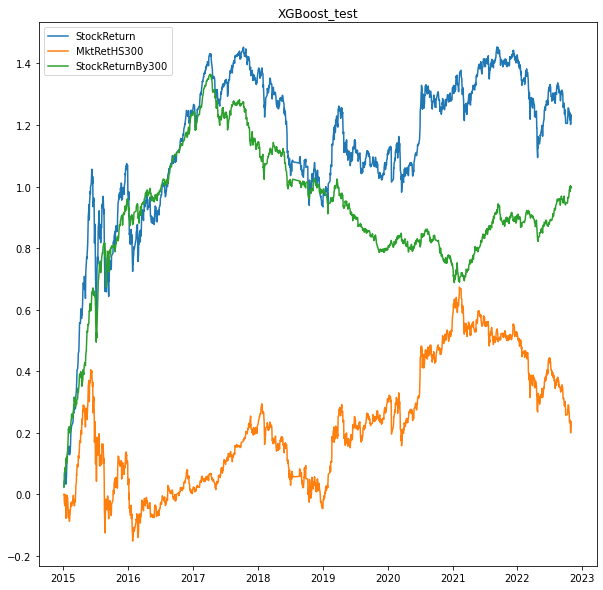

<Figure size 720x432 with 0 Axes>

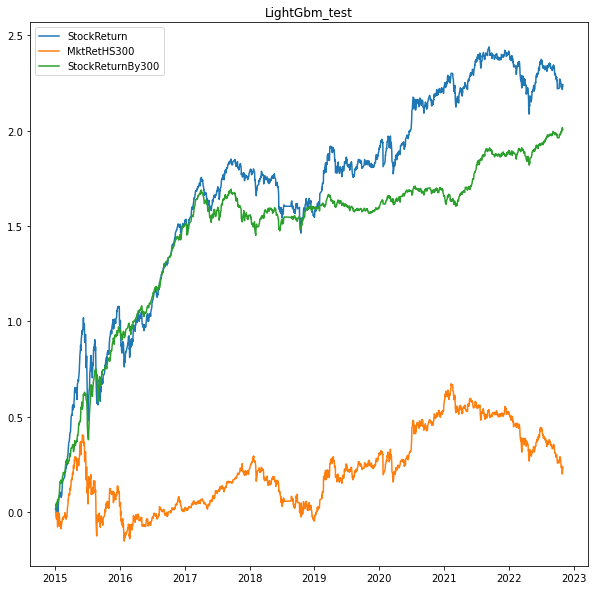

<Figure size 720x432 with 0 Axes>

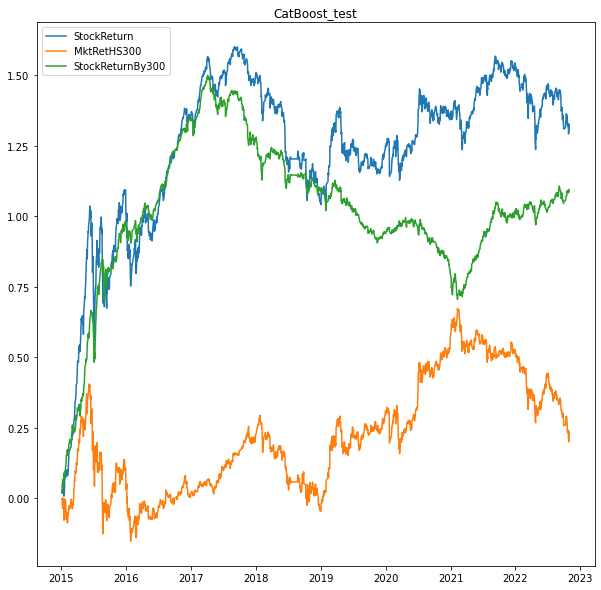

In [19]:
##PLotting

cost=0.0016
test_stat_all=[]
train_stat_all=[]
model_name_all=['XGBoost','LightGbm','CatBoost']
for i in np.arange(len(model_name_all)):
    tic=time.perf_counter()
    test_all=test_predict_all[i].copy()
    #train_all=train_predict_all[i].copy()
    model_name=model_name_all[i]
    test_all=test_all.drop(['StockReturn','MktRetHS300'],axis=1)
    test_all=pd.merge(test_all,StockReturn,on=['TradingDay','SecuCode'],how='inner')
    test_all['StockReturnBy300']=test_all['StockReturn']-test_all['MktRetHS300']
    #train_all['StockReturnBy300']=train_all['StockReturn']-train_all['MktRetHS300']
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    test_Holding_all=test_all.groupby('TradingDay').apply(lambda x:x.sort_values('predict',ascending=False).iloc[:50,:]).reset_index(drop=True)
    
    #train_Holding_all=train_all.groupby('TradingDay').apply(lambda x:x.sort_values('predict',ascending=False).iloc[:50,:]).reset_index(drop=True)
    
    test_plot,test_stat=get_stat_all(test_Holding_all,cost,model_name)
    #train_plot,train_stat=get_stat_all(train_Holding_all,cost,model_name)
    
    test_stat_all.append(test_stat.copy())
    #train_stat_all.append(train_stat.copy())
    
    #plt.subplot(1,2,1)
    plt.figure(figsize=(10,10))
    plt.plot(test_plot.index,test_plot['StockReturn'].cumsum(),label='StockReturn')
    plt.plot(test_plot.index,test_plot['MktRetHS300'].cumsum(),label='MktRetHS300')
    plt.plot(test_plot.index,test_plot['StockReturnBy300'].cumsum(),label='StockReturnBy300')
    plt.title(f"{model_name}_test")
    plt.legend()
    #plt.subplot(1,2,2)
    #plt.plot(train_plot.index,train_plot['StockReturn'].cumsum(),labellabel='StockReturn')
    #plt.plot(train_plot.index,train_plot['MktRetHS300'].cumsum(),label='MktRetHS300')
    #plt.plot(train_plot.index,train_plot['StockReturnBy300'].cumsum(),label='StockReturnBy300')
    #plt.title(f"{model_name}_train")
    #plt.legend()
    toc=(time.perf_counter()-tic)/60
    print(f"TTE:[{time.asctime()}] >> {toc:5.1f}min |model:{model_name_all[i]}")
test_stat_all=pd.concat(test_stat_all,axis=0,ignore_index=True)
#train_stat_all=pd.concat(train_stat_all,axis=0,ignore_index=True)

In [20]:
test_stat_all

,strategy,year_Return,year_std,year_sharpe,alpha,alpha_std,information,beta,maxdrawn,maxdrawn_alpha
0,XGBoost,0.165432,0.261500,0.632629,0.133823,0.137191,0.975447,0.961157,-0.518902,-0.676741
1,LightGbm,0.300808,0.270085,1.113753,0.269224,0.146984,1.831652,0.977721,-0.541196,-0.249335
2,CatBoost,0.177772,0.263156,0.675537,0.146177,0.141967,1.029656,0.956836,-0.558886,-0.793942


In [21]:
importance

,importance
market_cap,0.084796
pe,0.020761
pb,0.025261
ps,0.015374
net_profit_margin_on_sales,0.011032
gross_sales_profits,0.013913
weighted_roe,0.022448
roa,0.016637
before_tax_profit_div_income,0.008105
net_profit_div_income,0.010787


In [22]:
train_names

['bias',
 'vstd',
 'vmacd',
 'market_cap',
 'boll',
 'opt_profit_growth_ratio',
 'pb',
 'weighted_roe',
 'pe',
 'ps',
 'int_debt_equity',
 'gross_sales_profits',
 'quick_ratio',
 'turnover_of_overall_assets',
 'net_profit_margin_on_sales']

In [25]:
Return_300.columns

Index(['TradingDay', 'SecuCode', 'market_cap', 'pe', 'pb', 'ps',
       'net_profit_margin_on_sales', 'gross_sales_profits', 'weighted_roe',
       'roa', 'before_tax_profit_div_income', 'net_profit_div_income',
       'opt_profit_growth_ratio', 'net_profit_growth_ratio', 'net_debt_equity',
       'turnover_of_overall_assets', 'current_ratio', 'quick_ratio',
       'int_debt_equity', 'ma', 'expma', 'macd', 'bias', 'boll', 'vma',
       'vmacd', 'vstd', 'StockReturn', 'MktRetHS300', 'weight',
       'FirstIndustryCode', 'StockReturnBy300'],
      dtype='object')